In [43]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from scipy.sparse import csr_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

20 newsgroups dataset - 20000 features and 500 samples

In [44]:
categories = ['alt.atheism', 'talk.religion.misc']
data = fetch_20newsgroups(subset='train', categories=categories)

vectorizer = TfidfVectorizer(max_features=20000)
X = vectorizer.fit_transform(data.data)  
y = data.target
X = X[:500]
y = y[:500]
y = 2 * (y - 0.5)

Modification of DCD for sparse data

In [45]:
def dual_coordinate_descent_sparse(X, y, C=1.0, tol=1e-3, max_iter=100):

    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)

    for it in range(max_iter):
        alpha_old = alpha.copy()
        for i in np.random.permutation(l):
            xi = X[i]
            yi = y[i]
            wxi = xi.dot(w)[0]
            G = yi * wxi - 1 + D * alpha[i]

            if alpha[i] == 0 and G >= 0:
                continue
            elif alpha[i] == np.inf and G <= 0:
                continue
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                continue

            Qii = xi.multiply(xi).sum() + D
            alpha_i_old = alpha[i]
            alpha[i] = alpha[i] - G / Qii
            alpha[i] = max(alpha[i], 0)

            delta = (alpha[i] - alpha_i_old) * yi
            w[xi.indices] += delta * xi.data
            
        diff = np.linalg.norm(alpha - alpha_old)
        if diff < tol:
            print(f"Convergence reached at iteration {it}")
            break
    return w, alpha

Modification of ameliorations for DCD

In [46]:
def dcd_random_perm_sparse(X, y, C=1.0, tol=1e-3, max_iter=100):
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)

    for it in range(max_iter):
        alpha_old = alpha.copy()
        for i in np.random.permutation(l):
            xi = X.getrow(i)        
            yi = y[i]

            G = yi * xi.dot(w) - 1 + D * alpha[i]
            G = G.item()

            if alpha[i] == 0 and G >= 0:
                continue
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                continue

            Qii = xi.multiply(xi).sum() + D

            alpha_i_old = alpha[i]
            alpha[i] = max(alpha[i] - G / Qii, 0)

            delta = (alpha[i] - alpha_i_old) * yi

            for idx in range(xi.indices.size):
                j = xi.indices[idx]
                val = xi.data[idx]
                w[j] += delta * val

        if np.linalg.norm(alpha - alpha_old) < tol:
            print(f"Converged after {it} iterations")
            break

    return w, alpha


def dcd_online_sparse(X, y, C=1.0, tol=1e-3, max_iter=10000):
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)
    alpha_old = alpha.copy()

    for it in range(max_iter):
        i = np.random.randint(0, l)
        xi = X.getrow(i)  
        yi = y[i]

        G = yi * xi.dot(w) - 1 + D * alpha[i]
        G = G.item()  

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < np.inf and abs(G) < tol:
            continue

        Qii = xi.multiply(xi).sum() + D
        alpha_i_old = alpha[i]
        alpha[i] = max(alpha[i] - G / Qii, 0)

        delta = (alpha[i] - alpha_i_old) * yi

        for idx in range(xi.indices.size):
            j = xi.indices[idx]
            val = xi.data[idx]
            w[j] += delta * val

        if it % l == 0:
            if np.linalg.norm(alpha - alpha_old) < tol:
                print(f"Converged after {it} iterations")
                break
            alpha_old = alpha.copy()

    return w, alpha


def dcd_with_shrinking_sparse(X, y, C=1.0, tol=1e-3, max_iter=100):
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)
    active_set = np.ones(l, dtype=bool)  

    for k in range(max_iter):
        G_max = -np.inf
        G_min = np.inf

        for i in np.random.permutation(np.where(active_set)[0]):
            xi = X.getrow(i)
            yi = y[i]

            G = yi * xi.dot(w) - 1 + D * alpha[i]
            G = G.item()

            if alpha[i] == 0 and G >= 0:
                pass
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                pass
            else:
                Qii = xi.multiply(xi).sum() + D
                alpha_i_old = alpha[i]
                alpha[i] = max(alpha[i] - G / Qii, 0)
                delta = (alpha[i] - alpha_i_old) * yi

                for idx in range(xi.indices.size):
                    j = xi.indices[idx]
                    val = xi.data[idx]
                    w[j] += delta * val

            if alpha[i] > 0 and alpha[i] < np.inf:
                G_proj = G
            elif alpha[i] == 0:
                G_proj = min(0, G)
            else:  
                G_proj = max(0, G)

            G_max = max(G_max, G_proj)
            G_min = min(G_min, G_proj)

        G_max_bar = G_max if G_max > 0 else np.inf
        G_min_bar = G_min if G_min < 0 else -np.inf

        for i in range(l):
            if not active_set[i]:
                continue
            xi = X.getrow(i)
            yi = y[i]
            G = yi * xi.dot(w) - 1 + D * alpha[i]
            G = G.item()
            if (alpha[i] == 0 and G > G_max_bar) or (alpha[i] == np.inf and G < G_min_bar):
                active_set[i] = False

        if G_max - G_min < tol:
            print(f"Shrinking convergence at iteration {k}")
            break

        if np.sum(active_set) == 0:
            active_set[:] = True  

    return w, alpha


simple DCD and sklearn comparison - accuracy and time

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [48]:
start = time.time()
w, alpha = dual_coordinate_descent_sparse(X_train, y_train)
print("DCD training time:", time.time() - start)

preds = np.sign(X_test @ w)
accuracy = np.mean(preds == y_test)
print("DCD test accuracy:", accuracy)

Convergence reached at iteration 11
DCD training time: 0.15107393264770508
DCD test accuracy: 0.94


In [49]:
model = LinearSVC(dual=True, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
print("Sklearn time:", time.time() - start)
print("Accuracy for sklearn:", model.score(X_test, y_test))

Sklearn time: 0.0037162303924560547
Accuracy for sklearn: 0.94


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/sparsefuncs.py:734: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/sparsefuncs.py:734: RuntimeWarning: overflow encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/sparsefuncs.py:734: RuntimeWarning: invalid value encountered in matmul
  matvec=lambda x: X @ x - offset @ x,


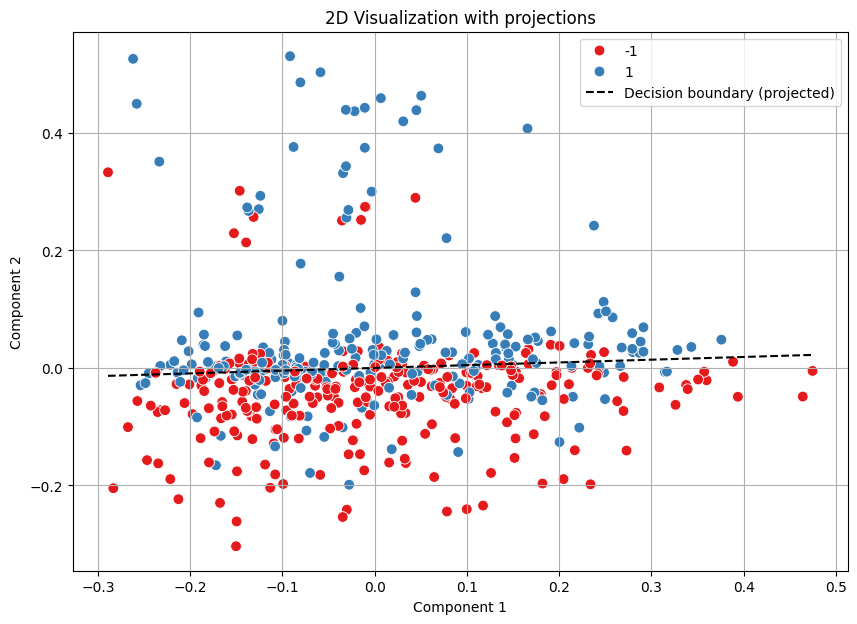

In [50]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

w_2d = pca.transform([w])[0]  

df = pd.DataFrame({
    'PC1': X_2d[:, 0],
    'PC2': X_2d[:, 1],
    'Label': y.astype(int)
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette='Set1', s=60)

slope = -w_2d[0] / w_2d[1] if w_2d[1] != 0 else 0
x_vals = np.linspace(df['PC1'].min(), df['PC1'].max(), 100)
y_vals = slope * x_vals

plt.plot(x_vals, y_vals, '--', color='black', label='Decision boundary (projected)')
plt.title("2D Visualization with projections")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

Average time of dot product for 100 calculations

In [51]:
N = 100
total_time = 0

for i in np.random.choice(X.shape[0], size=N, replace=False):
    xi = X[i]
    start = time.perf_counter()
    _ = xi @ w
    end = time.perf_counter()
    total_time += (end - start)

print(f"Average time of dot product: {total_time / N:.6f} seconds")

Average time of dot product: 0.000003 seconds


DCD wth ameliorations - comparison of execution time and accuracy

Convergence reached at iteration 6
DCD L2-SVM - Time: 0.1153s - Accuracy: 0.9940
Converged after 7 iterations
Random Permutation - Time: 0.1989s - Accuracy: 0.9940
Online - Time: 0.0076s - Accuracy: 0.7900
With Shrinking - Time: 1.2065s - Accuracy: 0.9940


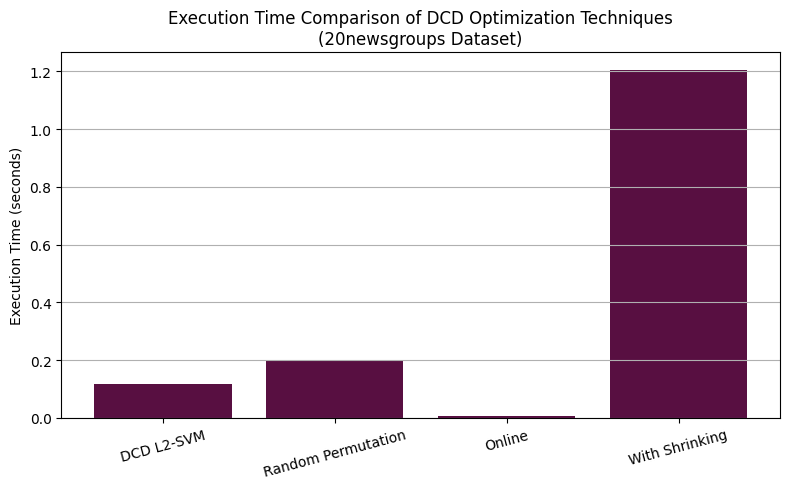

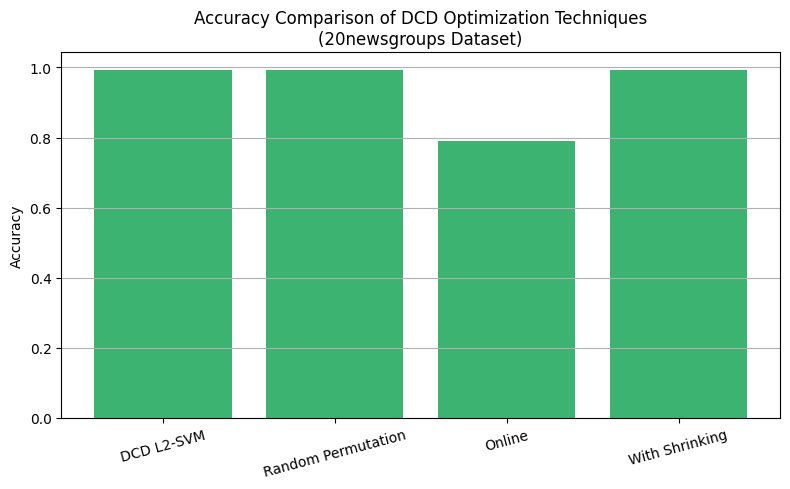

In [52]:
methods = {
    "DCD L2-SVM": dual_coordinate_descent_sparse,
    "Random Permutation": dcd_random_perm_sparse,
    "Online": dcd_online_sparse,
    "With Shrinking": dcd_with_shrinking_sparse
}

timings = {}
accuracies = {}

for name, method in methods.items():
    start = time.time()
    w, alpha = method(X, y, C=0.2, tol=1e-3, max_iter=100)
    elapsed = time.time() - start
    timings[name] = elapsed

    y_pred = np.sign(X @ w)
    accuracy = accuracy_score(y, y_pred)
    accuracies[name] = accuracy
    print(f"{name} - Time: {elapsed:.4f}s - Accuracy: {accuracy:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(timings.keys(), timings.values(), color='xkcd:plum')
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison of DCD Optimization Techniques\n(20newsgroups Dataset)")
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='mediumseagreen')
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of DCD Optimization Techniques\n(20newsgroups Dataset)")
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

DCD and SVC from sklearn (Quadratic programming) - comparison

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

start = time.time()
w_dcd, _ = dual_coordinate_descent_sparse(X_train, y_train)
time_dcd = time.time() - start

preds_dcd = np.sign(X_test @ w_dcd)
acc_dcd = accuracy_score(y_test, preds_dcd)

print(f"[DCD]     Accuracy: {acc_dcd:.4f} | Time: {time_dcd:.4f}s")

svc = SVC(kernel='linear') 
start = time.time()
svc.fit(X_train, y_train)
time_qp = time.time() - start

acc_qp = svc.score(X_test, y_test)
print(f"[SVC QP]  Accuracy: {acc_qp:.4f} | Time: {time_qp:.4f}s")

model = LinearSVC(dual=True, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
time_svc_dual = time.time() - start
acc_svc_dual = svc.score(X_test, y_test)
print(f"[SVC dual]  Accuracy: {acc_svc_dual:.4f} | Time: {time_svc_dual:.4f}s")

model = LinearSVC(dual=False, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
time_svc_primal = time.time() - start
acc_svc_primal = svc.score(X_test, y_test)
print(f"[SVC dual]  Accuracy: {acc_svc_primal:.4f} | Time: {time_svc_primal:.4f}s")


Convergence reached at iteration 11
[DCD]     Accuracy: 0.9400 | Time: 0.1687s
[SVC QP]  Accuracy: 0.9200 | Time: 0.1110s
[SVC dual]  Accuracy: 0.9200 | Time: 0.0054s
[SVC dual]  Accuracy: 0.9200 | Time: 0.0073s


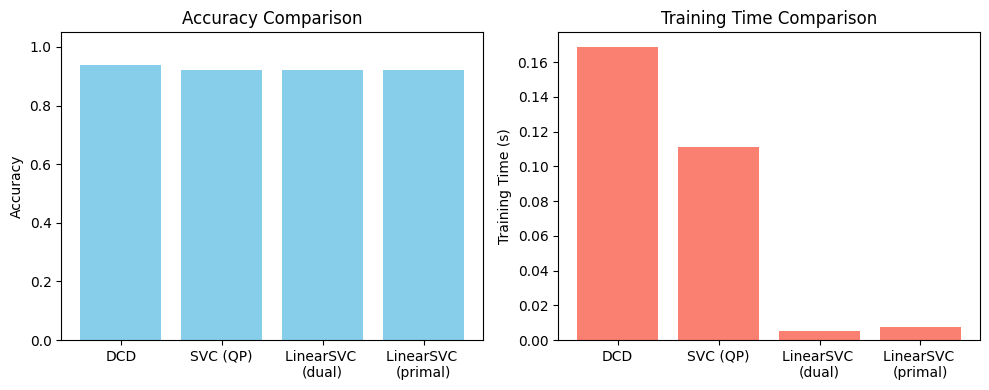

In [54]:
methods = ['DCD', 'SVC (QP)', 'LinearSVC \n(dual)', 'LinearSVC \n(primal)']

accuracies = [acc_dcd, acc_qp, acc_svc_dual, acc_svc_primal]
times = [time_dcd, time_qp, time_svc_dual, time_svc_primal]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(methods, accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.05)
plt.title("Accuracy Comparison")

plt.subplot(1, 2, 2)
plt.bar(methods, times, color='salmon')
plt.ylabel("Training Time (s)")
plt.title("Training Time Comparison")

plt.tight_layout()
plt.show()

Tests of generated sparse dataset

In [55]:
X_dense, y = make_classification(
    n_samples=10000,
    n_features=10000,
    n_informative=50,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

X_dense[np.abs(X_dense) < 5.0] = 0

X_sparse = csr_matrix(X_dense)

y = 2 * y - 1

density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
print(f"Sparse matrix shape: {X_sparse.shape}")
print(f"Non-zero elements: {X_sparse.nnz} ({density:.4f}% density)")

Sparse matrix shape: (10000, 10000)
Non-zero elements: 116525 (0.1165% density)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.2, random_state=42, stratify=y
)

start = time.time()
w_dcd, _ = dual_coordinate_descent_sparse(X_train, y_train)
time_dcd = time.time() - start

preds_dcd = np.sign(X_test @ w_dcd)
acc_dcd = accuracy_score(y_test, preds_dcd)

print(f"[DCD]     Accuracy: {acc_dcd:.4f} | Time: {time_dcd:.4f}s")

svc = SVC(kernel='linear') 
start = time.time()
svc.fit(X_train, y_train)
time_qp = time.time() - start

acc_qp = svc.score(X_test, y_test)
print(f"[SVC QP]  Accuracy: {acc_qp:.4f} | Time: {time_qp:.4f}s")

model = LinearSVC(dual=True, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
time_svc_dual = time.time() - start
acc_svc_dual = svc.score(X_test, y_test)
print(f"[SVC dual]  Accuracy: {acc_svc_dual:.4f} | Time: {time_svc_dual:.4f}s")

model = LinearSVC(dual=False, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
time_svc_primal = time.time() - start
acc_svc_primal = svc.score(X_test, y_test)
print(f"[SVC primal]  Accuracy: {acc_svc_primal:.4f} | Time: {time_svc_primal:.4f}s")


[DCD]     Accuracy: 0.6240 | Time: 29.1933s
[SVC QP]  Accuracy: 0.7575 | Time: 17.6455s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[SVC dual]  Accuracy: 0.7575 | Time: 0.2232s
[SVC primal]  Accuracy: 0.7575 | Time: 0.0125s


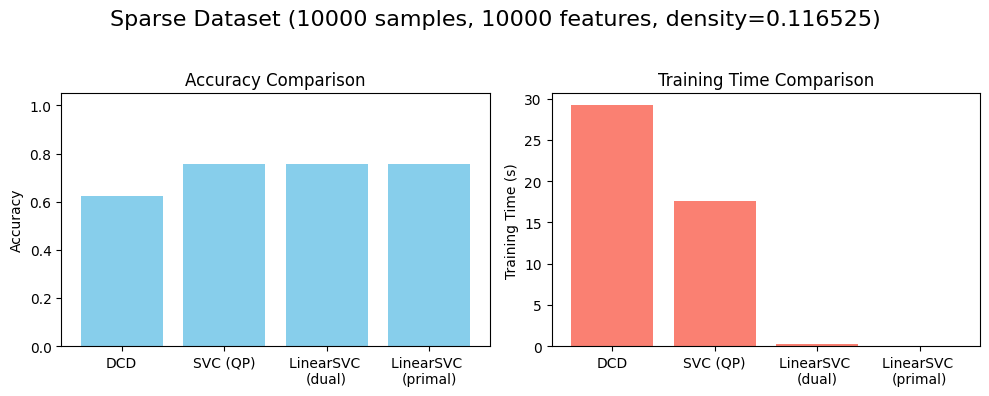

In [57]:
methods = ['DCD', 'SVC (QP)', 'LinearSVC \n(dual)', 'LinearSVC \n(primal)']

accuracies = [acc_dcd, acc_qp, acc_svc_dual, acc_svc_primal]
times = [time_dcd, time_qp, time_svc_dual, time_svc_primal]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(methods, accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.05)
plt.title("Accuracy Comparison")

plt.subplot(1, 2, 2)
plt.bar(methods, times, color='salmon')
plt.ylabel("Training Time (s)")
plt.title("Training Time Comparison")

plt.suptitle(f"Sparse Dataset (10000 samples, 10000 features, density={density})", fontsize=16)  
plt.tight_layout(rect=[0, 0, 1, 0.95])       
plt.show()

Sparse matrix shape: (100, 10000)
Non-zero elements: 1202 (0.1202% density)
Convergence reached at iteration 85
[DCD]     Accuracy: 0.6000 | Time: 0.2131s
[SVC QP]  Accuracy: 0.7000 | Time: 0.0013s
[SVC dual]  Accuracy: 0.7000 | Time: 0.0014s
[SVC primal]  Accuracy: 0.7000 | Time: 0.0195s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


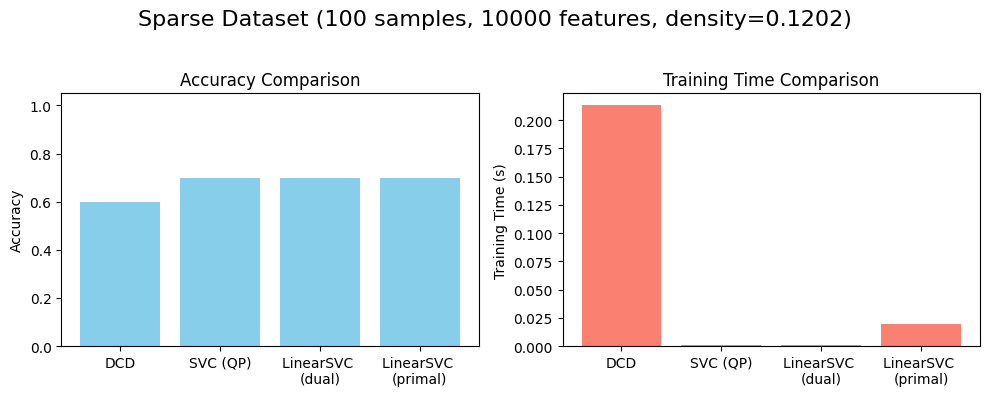

In [58]:
X_dense, y = make_classification(
    n_samples=100,
    n_features=10000,
    n_informative=50,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

X_dense[np.abs(X_dense) < 5.0] = 0

X_sparse = csr_matrix(X_dense)

y = 2 * y - 1

density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
print(f"Sparse matrix shape: {X_sparse.shape}")
print(f"Non-zero elements: {X_sparse.nnz} ({density:.4f}% density)")

X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.2, random_state=42, stratify=y
)

start = time.time()
w_dcd, _ = dual_coordinate_descent_sparse(X_train, y_train)
time_dcd = time.time() - start

preds_dcd = np.sign(X_test @ w_dcd)
acc_dcd = accuracy_score(y_test, preds_dcd)

print(f"[DCD]     Accuracy: {acc_dcd:.4f} | Time: {time_dcd:.4f}s")

svc = SVC(kernel='linear') 
start = time.time()
svc.fit(X_train, y_train)
time_qp = time.time() - start

acc_qp = svc.score(X_test, y_test)
print(f"[SVC QP]  Accuracy: {acc_qp:.4f} | Time: {time_qp:.4f}s")

model = LinearSVC(dual=True, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
time_svc_dual = time.time() - start
acc_svc_dual = svc.score(X_test, y_test)
print(f"[SVC dual]  Accuracy: {acc_svc_dual:.4f} | Time: {time_svc_dual:.4f}s")

model = LinearSVC(dual=False, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
time_svc_primal = time.time() - start
acc_svc_primal = svc.score(X_test, y_test)
print(f"[SVC primal]  Accuracy: {acc_svc_primal:.4f} | Time: {time_svc_primal:.4f}s")

methods = ['DCD', 'SVC (QP)', 'LinearSVC \n(dual)', 'LinearSVC \n(primal)']

accuracies = [acc_dcd, acc_qp, acc_svc_dual, acc_svc_primal]
times = [time_dcd, time_qp, time_svc_dual, time_svc_primal]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(methods, accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.05)
plt.title("Accuracy Comparison")

plt.subplot(1, 2, 2)
plt.bar(methods, times, color='salmon')
plt.ylabel("Training Time (s)")
plt.title("Training Time Comparison")

plt.suptitle(f"Sparse Dataset (100 samples, 10000 features, density={density})", fontsize=16)  
plt.tight_layout(rect=[0, 0, 1, 0.95])       
plt.show()

[DCD]     Accuracy: 0.9649 | Time: 0.0365s
[SVC QP]  Accuracy: 0.9737 | Time: 0.0011s
[SVC dual]  Accuracy: 0.9737 | Time: 0.0018s
[SVC primal]  Accuracy: 0.9737 | Time: 0.0006s


/var/folders/_n/4cslc53j6ls8_fsjchkctxkh0000gn/T/ipykernel_1579/3784271580.py:65: RuntimeWarning: divide by zero encountered in matmul
  preds_dcd = np.sign(X_test @ w_dcd)
/var/folders/_n/4cslc53j6ls8_fsjchkctxkh0000gn/T/ipykernel_1579/3784271580.py:65: RuntimeWarning: overflow encountered in matmul
  preds_dcd = np.sign(X_test @ w_dcd)
/var/folders/_n/4cslc53j6ls8_fsjchkctxkh0000gn/T/ipykernel_1579/3784271580.py:65: RuntimeWarning: invalid value encountered in matmul
  preds_dcd = np.sign(X_test @ w_dcd)


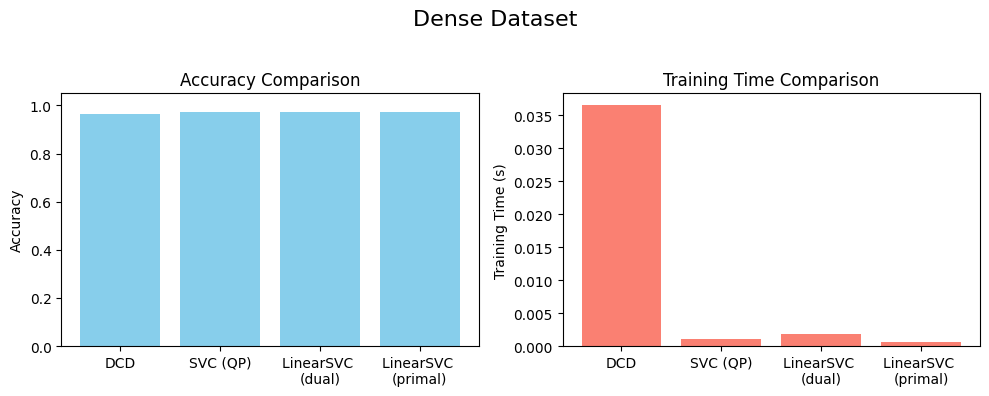

In [59]:
data = load_breast_cancer()
X = data.data
y = data.target
y = 2 * (y - 0.5) 
X = StandardScaler().fit_transform(X)

def dual_coordinate_descent_l2_svm(X, y, C=1.0, tol=1e-3, max_iter=100):
    """
    Dual Coordinate Descent algorithm implementation for L2-SVM
    X : (l x n) feature matrix
    y : (l,) label vector {-1, +1}
    C : regularization parameter
    tol : convergence tolerance
    max_iter : maximum number of outer iterations
    """
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)  # L2-SVM => Dii = 1/(2C)

    for it in range(max_iter):
        alpha_old = alpha.copy()

        for i in np.random.permutation(l):  # random permutation
            xi = X[i]
            yi = y[i]

            G = yi * np.dot(w, xi) - 1 + D * alpha[i]

            # Projected gradient
            if alpha[i] == 0 and G >= 0:
                continue
            elif alpha[i] == np.inf and G <= 0:
                continue
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                continue

            # Update alpha_i
            Qii = np.dot(xi, xi) + D
            alpha_i_old = alpha[i]
            alpha[i] = alpha[i] - G / Qii
            # No upper bound for L2-SVM (U = ∞), but we ensure alpha[i] ≥ 0
            alpha[i] = max(alpha[i], 0)

            # Update w
            w += (alpha[i] - alpha_i_old) * yi * xi

        # Simple stopping criterion (change in alphas)
        diff = np.linalg.norm(alpha - alpha_old)
        if diff < tol:
            print(f"Convergence reached at iteration {it}")
            break

    return w, alpha


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

start = time.time()
w_dcd, _ = dual_coordinate_descent_l2_svm(X_train, y_train)
time_dcd = time.time() - start

preds_dcd = np.sign(X_test @ w_dcd)
acc_dcd = accuracy_score(y_test, preds_dcd)

print(f"[DCD]     Accuracy: {acc_dcd:.4f} | Time: {time_dcd:.4f}s")

svc = SVC(kernel='linear') 
start = time.time()
svc.fit(X_train, y_train)
time_qp = time.time() - start

acc_qp = svc.score(X_test, y_test)
print(f"[SVC QP]  Accuracy: {acc_qp:.4f} | Time: {time_qp:.4f}s")

model = LinearSVC(dual=True, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
time_svc_dual = time.time() - start
acc_svc_dual = svc.score(X_test, y_test)
print(f"[SVC dual]  Accuracy: {acc_svc_dual:.4f} | Time: {time_svc_dual:.4f}s")

model = LinearSVC(dual=False, penalty='l2')
start = time.time()
model.fit(X_train, y_train)
time_svc_primal = time.time() - start
acc_svc_primal = svc.score(X_test, y_test)
print(f"[SVC primal]  Accuracy: {acc_svc_primal:.4f} | Time: {time_svc_primal:.4f}s")

methods = ['DCD', 'SVC (QP)', 'LinearSVC \n(dual)', 'LinearSVC \n(primal)']

accuracies = [acc_dcd, acc_qp, acc_svc_dual, acc_svc_primal]
times = [time_dcd, time_qp, time_svc_dual, time_svc_primal]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(methods, accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.05)
plt.title("Accuracy Comparison")

plt.subplot(1, 2, 2)
plt.bar(methods, times, color='salmon')
plt.ylabel("Training Time (s)")
plt.title("Training Time Comparison")

plt.suptitle("Dense Dataset", fontsize=16)  

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

In [ ]:
n_of_samples = [100, 200, 500, 1000]

for i in n_of_samples:
    